In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

<font size="5"> **Compute moving average array: $x(t) \to \mu_\lambda(t)$** </font>

In [8]:
#lambdas = [3, 5, 7, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200]
lambdas = np.arange(1, 201)
warmup_period = lambdas[-1]
mu_window = 5

x_warmup = pd.read_csv('SPY-daily-2021-2023.csv', header=0, usecols=['Date', 'Close'], nrows=warmup_period)
x_data = pd.read_csv('SPY-daily-2021-2023.csv', header=0, usecols=['Date', 'Close'], skiprows=range(1,warmup_period+1))

,Date,Close
0,2021-03-15,396.410004
1,2021-03-16,395.910004
2,2021-03-17,397.260010
3,2021-03-18,391.480011
4,2021-03-19,389.480011
...,...,...
195,2021-12-20,454.980011
196,2021-12-21,463.059998
197,2021-12-22,467.690002
198,2021-12-23,470.600006


In [105]:
class DataTransform:
    def __init__(self, x_data):
        self.x = x_data
        self.mu = pd.DataFrame(np.zeros((mu_window, len(lambdas))), columns=lambdas)
        
    def updateData(self, data_new):
        self.x = self.x.append(data_new, ignore_index=True)
        self.x.drop(index=0, inplace=True)
        self.x.reset_index(drop=True, inplace=True)
        return self.x
        
    def warmupSMA(self, x, lambdas, delta_t):
        # delta_t will shift the averaging window back
        # x will need to be padded by the same ammount

        mu = np.zeros(len(lambdas))
        t0 = len(x)
        if delta_t > 0:
            x = np.pad(x, (delta_t, 0), 'edge')
            t0 += delta_t   # t0 needs to reference the last element in x. when we pad x, x.shape += delta_t

        for i, l in enumerate(lambdas):
            data = x[t0 - l - delta_t : t0 - delta_t]
            mu[i] = np.mean(data)
        return mu
    
    def updateMu(self, x_new):
        # run BEFORE updataData since this requires oldest data value
        new_mu = np.zeros((len(lambdas)))
        
        for i, l in enumerate(lambdas):
            t0 = len(self.x.index)
            x_old = self.x.loc[t0-l, 'Close']
            new_mu[i] = self.mu.loc[mu_window-1, l] + (x_new - x_old)/l
            
        self.mu.loc[-1] = new_mu
        self.mu.drop(index=0, inplace=True)
        self.mu.reset_index(drop=True, inplace=True)
        return self.mu
    
    def get_x_data(self):
        return self.x

In [106]:
dt = DataTransform(x_warmup)
dt.x

,Date,Close
0,2021-03-15,396.410004
1,2021-03-16,395.910004
2,2021-03-17,397.260010
3,2021-03-18,391.480011
4,2021-03-19,389.480011
...,...,...
195,2021-12-20,454.980011
196,2021-12-21,463.059998
197,2021-12-22,467.690002
198,2021-12-23,470.600006


In [40]:
dt.updateData(x_data.loc[2])
dt.x

,Date,Close
0,2021-03-18,391.480011
1,2021-03-19,389.480011
2,2021-03-22,392.589996
3,2021-03-23,389.500000
4,2021-03-24,387.519989
...,...,...
195,2021-12-23,470.600006
196,2021-12-27,477.260010
197,2021-12-28,476.869995
198,2021-12-29,477.480011


In [82]:
dt.mu

,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
for delta_t in range(mu_window):
    dt.mu.loc[mu_window-delta_t-1] = dt.warmupSMA(x_warmup['Close'].values, lambdas, delta_t)
dt.mu

,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
0,454.980011,457.425003,460.433339,462.975006,463.052002,463.638336,464.652858,464.865002,465.382222,465.672000,...,435.949842,435.707812,435.478652,435.281649,435.079743,434.882448,434.687157,434.493838,434.302462,434.11300
1,463.059998,459.020005,459.303335,461.090004,462.992004,463.053335,463.555716,464.453751,464.664446,465.150000,...,436.318795,436.091041,435.849533,435.620824,435.424102,435.222499,435.025482,434.830454,434.637386,434.44625
2,467.690002,465.375000,461.910004,461.400002,462.410004,463.775004,463.715716,464.072502,464.813334,464.967001,...,436.728167,436.482187,436.254766,436.013659,435.785281,435.588724,435.387309,435.190454,434.995577,434.80265
3,470.600006,469.145004,467.116669,464.082504,463.240002,463.775004,464.750004,464.576252,464.797780,465.392001,...,437.163141,436.904583,436.658963,436.431803,436.191025,435.962908,435.766446,435.565151,435.368391,435.17360
4,477.260010,473.930008,471.850006,469.652504,466.718005,465.576670,465.701433,466.313755,465.985558,466.044003,...,437.621570,437.371979,437.113678,436.868247,436.641179,436.400561,436.172538,435.976010,435.774673,435.57785


In [108]:
dt.updateMu(x_data.loc[0, 'Close'])
dt.mu

,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
0,463.059998,459.020005,459.303335,461.090004,462.992004,463.053335,463.555716,464.453751,464.664446,465.150000,...,436.318795,436.091041,435.849533,435.620824,435.424102,435.222499,435.025482,434.830454,434.637386,434.44625
1,467.690002,465.375000,461.910004,461.400002,462.410004,463.775004,463.715716,464.072502,464.813334,464.967001,...,436.728167,436.482187,436.254766,436.013659,435.785281,435.588724,435.387309,435.190454,434.995577,434.80265
2,470.600006,469.145004,467.116669,464.082504,463.240002,463.775004,464.750004,464.576252,464.797780,465.392001,...,437.163141,436.904583,436.658963,436.431803,436.191025,435.962908,435.766446,435.565151,435.368391,435.17360
3,477.260010,473.930008,471.850006,469.652504,466.718005,465.576670,465.701433,466.313755,465.985558,466.044003,...,437.621570,437.371979,437.113678,436.868247,436.641179,436.400561,436.172538,435.976010,435.774673,435.57785
4,476.869995,477.065002,474.910004,473.105003,471.096002,468.410004,467.190002,467.097504,467.486671,467.074002,...,438.045078,437.825989,437.576632,437.318608,437.073384,436.846428,436.605989,436.378080,436.181507,435.98015


In [22]:
# Batch SMA for entire dataset

def SMA(x, l):
    x_len = len(x)
    x = np.pad(x, (l, 0), 'edge')
    window = np.zeros(l)
    mu = np.zeros(x_len)

    for i in range(x_len):
        window = x[i:i+l]
        mu[i] = np.ma.average(window)
    return mu

In [10]:
def warmupSMA(x, lambdas, delta_t):
    # delta_t will shift the averaging window back
    # x will need to be padded by the same ammount
    
    mu = np.zeros(len(lambdas))
    t0 = len(x)
    if delta_t > 0:
        x = np.pad(x, (delta_t, 0), 'edge')
        t0 += delta_t   # t0 needs to reference the last element in x. when we pad x, x.shape += delta_t

    for i, l in enumerate(lambdas):
        data = x[t0 - l - delta_t : t0 - delta_t]
        mu[i] = np.mean(data)
    return mu

In [28]:
def updateSMA(x_old, x_new, mu_old, l):
    mu_new = mu_old + (x_new - x_old)/l
    return mu_new

In [474]:
def muArray(x, lambdas):
    mu = np.zeros((len(x), len(lambdas)))
    
    for l in range(len(lambdas)):
        mu[:, l] = SMA(x, lambdas[l])
    
    return mu

In [48]:
window = 5  # used for calculating the slope of mu as a linear fit

mu = pd.DataFrame(np.zeros((window, len(lambdas))), columns=lambdas)
for delta_t in range(window):
    mu.loc[window-delta_t-1] = warmupSMA(x_warmup['Close'].values, lambdas, delta_t)
mu

,3,5,7,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200
0,460.433339,463.052002,464.652858,465.672000,463.058002,464.520001,463.518001,459.790601,455.614668,453.667144,453.320001,452.392556,451.295101,448.566500,444.954571,441.370937,438.395555,434.11300
1,459.303335,462.992004,463.555716,465.150000,462.832501,464.324335,463.705751,460.358000,455.955001,453.902573,453.480126,452.583001,451.540601,448.838417,445.270928,441.666625,438.709277,434.44625
2,461.910004,462.410004,463.715716,464.967001,462.807501,464.334668,463.999001,461.039401,456.521167,454.238572,453.673376,452.813223,451.841601,449.121500,445.593000,441.970500,439.037999,434.80265
3,467.116669,463.240002,464.750004,465.392001,462.865501,464.567335,464.415501,461.747801,457.123667,454.563144,453.911376,453.108334,452.136101,449.435417,445.938785,442.273500,439.366388,435.17360
4,471.850006,466.718005,465.701433,466.044003,463.780002,465.017002,464.889001,462.443001,457.925667,454.993001,454.229626,453.531445,452.518901,449.792083,446.331500,442.644250,439.730944,435.57785


In [ ]:
# Data Step Loop

for l in lambdas:
    mu[l] = updateSMA(x[t0-l], x_new, mu[l], l)

In [476]:
mu = pd.DataFrame(muArray(df['Close'], lambdas), columns=lambdas)
mu

,3,5,7,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200
0,396.410004,396.410004,396.410004,396.410004,396.410004,396.410004,396.410004,396.410004,396.410004,396.410004,396.410004,396.410004,396.410004,396.410004,396.410004,396.410004,396.410004,396.410004
1,396.410004,396.410004,396.410004,396.410004,396.410004,396.410004,396.410004,396.410004,396.410004,396.410004,396.410004,396.410004,396.410004,396.410004,396.410004,396.410004,396.410004,396.410004
2,396.243337,396.310004,396.338575,396.360004,396.385004,396.393337,396.397504,396.400004,396.401671,396.402861,396.403754,396.404448,396.405004,396.405837,396.406433,396.406879,396.407226,396.407504
3,396.526673,396.480005,396.460005,396.445005,396.427504,396.421671,396.418754,396.417004,396.415837,396.415004,396.414379,396.413893,396.413504,396.412921,396.412504,396.412192,396.411948,396.411754
4,394.883342,395.494007,395.755720,395.952005,396.181005,396.257338,396.295504,396.318404,396.333671,396.344576,396.352754,396.359115,396.364204,396.371837,396.377290,396.381379,396.384560,396.387104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,402.309997,399.895996,399.067143,398.905002,404.205002,405.063668,402.393500,398.306800,397.081167,397.561571,397.130750,395.293222,392.664900,389.354834,391.981572,394.031876,392.602111,393.156900
500,400.553334,400.732001,399.237143,398.943002,403.391502,405.021001,402.670001,398.670800,397.125834,397.511571,397.440625,395.481000,393.088500,389.390834,391.761715,394.073438,392.785778,393.204201
501,396.250000,399.482001,398.565713,398.033002,402.437003,404.728001,402.694501,398.843800,397.097167,397.357714,397.401500,395.609667,393.344400,389.402834,391.511072,394.053376,392.877389,393.213851
502,392.130005,395.826001,397.304286,396.986002,401.378003,404.100001,402.454251,398.934000,396.879834,397.214857,397.244000,395.575111,393.627200,389.405750,391.211215,393.972876,392.941389,393.158801


In [477]:
# df.index.values[:lambdas[-1]] returns array of index values from 0 to the max lambda
# We drop the first lambda_max data points because the SMA is warming up for those

df.drop(df.index.values[:lambdas[-1]], inplace=True)
df.reset_index(drop=True, inplace=True)

mu.drop(df.index.values[:lambdas[-1]], inplace=True)
mu.reset_index(drop=True, inplace=True)
mu

,3,5,7,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200
0,471.850006,466.718005,465.701433,466.044003,463.780002,465.017002,464.889001,462.443001,457.925667,454.993001,454.229626,453.531445,452.518901,449.792083,446.331500,442.644250,439.730944,435.577850
1,474.910004,471.096002,467.190002,467.074002,464.393501,465.337003,465.329501,463.063001,458.636167,455.499715,454.525626,453.942668,452.870001,450.175000,446.725928,443.035875,440.086555,435.980150
2,477.203339,473.980005,469.705719,468.486005,465.489502,465.672003,465.765501,463.668801,459.450167,456.120287,454.830626,454.321779,453.219901,450.524667,447.110714,443.486312,440.453388,436.388000
3,476.836670,475.674005,472.731432,469.042004,466.772502,465.901337,466.122002,464.179201,460.167834,456.727858,455.139376,454.642890,453.560201,450.850334,447.481071,443.898062,440.788333,436.782500
4,476.200002,476.546002,474.431431,469.893002,467.650502,466.128669,466.378001,464.630201,460.835501,457.257858,455.440001,454.942779,453.883001,451.178417,447.836071,444.262937,441.108888,437.199899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,402.309997,399.895996,399.067143,398.905002,404.205002,405.063668,402.393500,398.306800,397.081167,397.561571,397.130750,395.293222,392.664900,389.354834,391.981572,394.031876,392.602111,393.156900
300,400.553334,400.732001,399.237143,398.943002,403.391502,405.021001,402.670001,398.670800,397.125834,397.511571,397.440625,395.481000,393.088500,389.390834,391.761715,394.073438,392.785778,393.204201
301,396.250000,399.482001,398.565713,398.033002,402.437003,404.728001,402.694501,398.843800,397.097167,397.357714,397.401500,395.609667,393.344400,389.402834,391.511072,394.053376,392.877389,393.213851
302,392.130005,395.826001,397.304286,396.986002,401.378003,404.100001,402.454251,398.934000,396.879834,397.214857,397.244000,395.575111,393.627200,389.405750,391.211215,393.972876,392.941389,393.158801


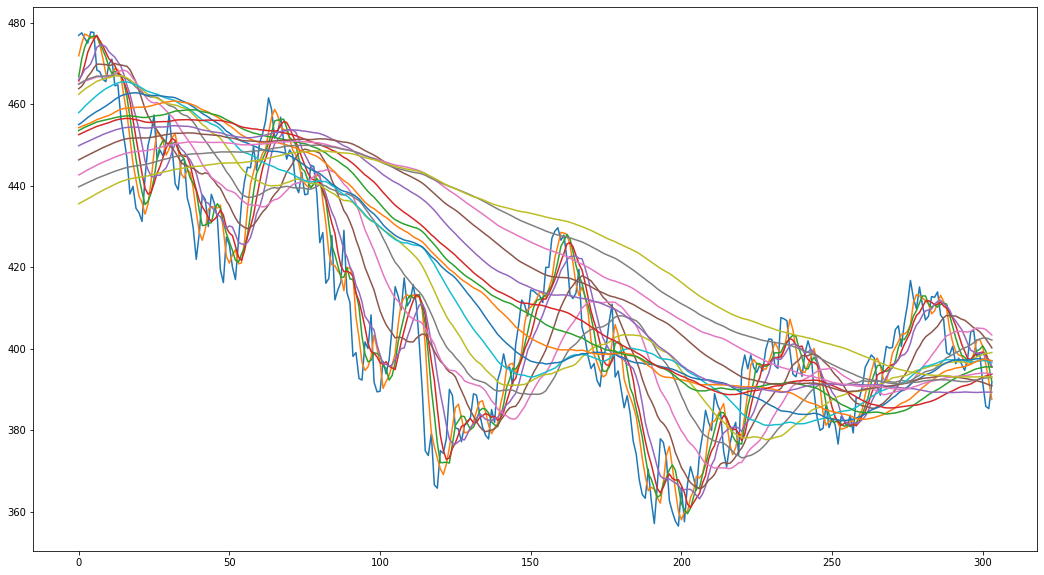

In [478]:
fig, ax = plt.subplots(figsize=(18,10))
ax.plot(df['Close'])
ax.plot(mu)
plt.show()

<font size="5"> **Compute linear fit $\mu_\lambda = \beta_0 + \beta_1\lambda + \beta_2\lambda^2 + \dots + \beta_n\lambda^n$** </font>

In [479]:
order = 8

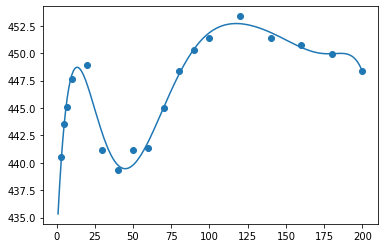

            8             7             6             5            4
-8.731e-15 x + 7.984e-12 x - 3.072e-09 x + 6.422e-07 x - 7.82e-05 x
             3          2
 + 0.005473 x - 0.2004 x + 3.087 x + 432.4


In [480]:
# testing the polyfit

polyfit = np.poly1d(np.polyfit(lambdas, mu.loc[75].values, order))

X = np.linspace(1,lambdas[-1], lambdas[-1])

plt.scatter(lambdas, mu.loc[75])
plt.plot(X, polyfit(X))
plt.show()
print(polyfit)

In [481]:
def betas(mu, lambdas):
    beta = np.empty(order+1)
    
    for i in range(len(mu.index)):
        polyfit = np.polyfit(lambdas, mu.loc[i].values, order)
        beta = np.vstack((beta, polyfit))
    beta = np.delete(beta, 0, axis=0)   # delete the first row since concatenation begins with the initialized zeros array
    
    return beta

In [482]:
beta = pd.DataFrame(betas(mu, lambdas))  # column names are reversed from beta_i
beta

,0,1,2,3,4,5,6,7,8
0,1.493907e-14,-1.301082e-11,4.669023e-09,-8.885261e-07,0.000096,-0.005828,0.183744,-2.643141,477.459358
1,1.596874e-14,-1.396679e-11,5.042043e-09,-9.677498e-07,0.000106,-0.006560,0.214313,-3.279706,482.818433
2,1.385818e-14,-1.225951e-11,4.482108e-09,-8.727337e-07,0.000097,-0.006145,0.206781,-3.335229,485.680008
3,7.865005e-15,-7.293237e-12,2.791948e-09,-5.684862e-07,0.000066,-0.004359,0.153204,-2.654008,484.542473
4,2.447345e-15,-2.800456e-12,1.260848e-09,-2.922002e-07,0.000038,-0.002717,0.103029,-1.982954,482.795132
...,...,...,...,...,...,...,...,...,...
299,2.993206e-14,-2.338788e-11,7.434186e-09,-1.235539e-06,0.000115,-0.005839,0.146312,-1.393730,404.179345
300,2.730146e-14,-2.125097e-11,6.719769e-09,-1.108829e-06,0.000102,-0.005109,0.124263,-1.088913,402.762482
301,2.224093e-14,-1.707584e-11,5.298309e-09,-8.508575e-07,0.000075,-0.003492,0.070998,-0.230050,397.412970
302,1.798979e-14,-1.355498e-11,4.091784e-09,-6.296005e-07,0.000052,-0.002048,0.021453,0.625725,391.235169


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

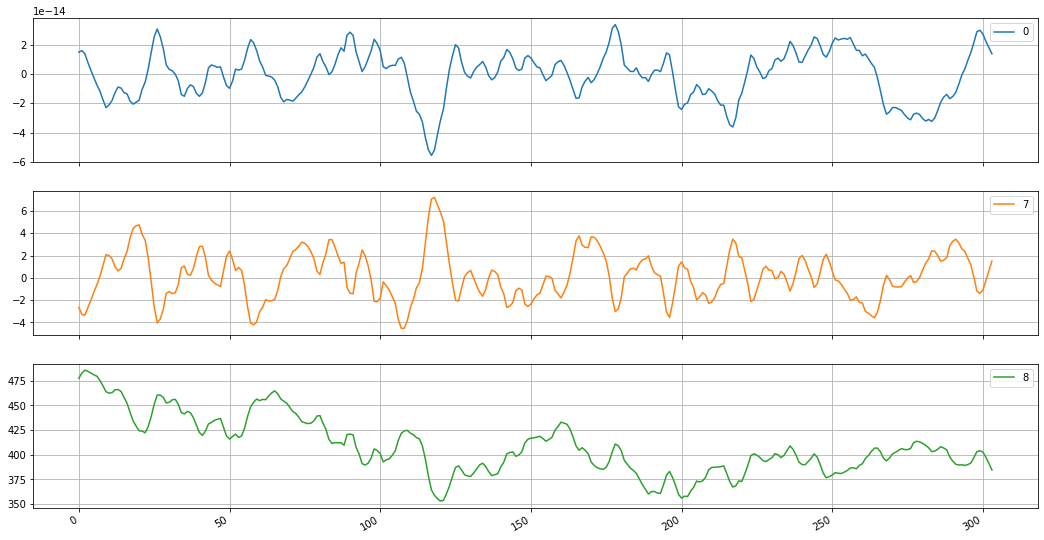

In [483]:
beta[[0, order-1, order]].plot(figsize=(18,10), grid=True, subplots=True)

<font size="5"> **Compute EMA Depth And Test Trade Signals**</font>

**This indicator creates an array of EMAs of various periods. It then tracks how many of these EMAs the price is above and below. The number of EMAs the price is above is called the Depth. It can range from 0 to the number of EMAs. We create a buy/sell trigger when the Depth rises above or below a threshold. Reults of testing are given for all values of the threshold.**

In [484]:
maxDepth = len(lambdas)

# Counts the number of EMAs the price is above at each time step
def countDepth(df, mu):
    countArray = np.zeros(len(df.index))
    
    for i in range(len(df.index)):
        count = 0
        for l in lambdas:
            if df.loc[i, 'Close'] > mu.loc[i, l]:
                count += 1
        countArray[i] = count
    return countArray

In [485]:
# Given a continuous signal, generate a +1 if the signal crosses above a threshold, and -1 if it crosses under
def trigger(signal, threshold):
    triggers = np.zeros(len(signal))
    
    prevVal = signal[0]
    
    for index, val in enumerate(signal):
        if val >= threshold and prevVal < threshold:
            triggers[index] = 1    # indicates a cross-over
        if val < threshold and prevVal >= threshold:
            triggers[index] = -1   # indicates a cross-under
            
        prevVal = val
        
    return triggers

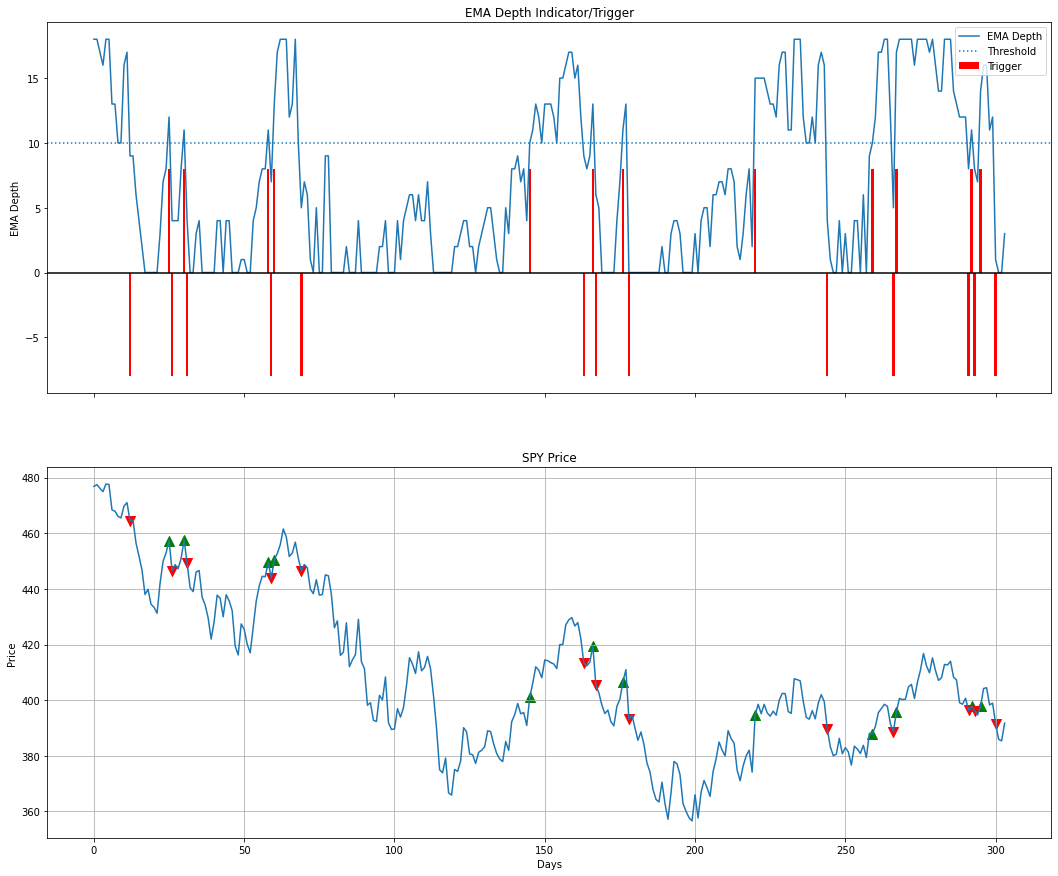

In [486]:
thresh = 10
X = df.index.values
depth = countDepth(df, mu)
triggers = trigger(countDepth(df, mu), thresh)

pos = [i for i, v in enumerate(triggers) if v==1]
neg = [i for i, v in enumerate(triggers) if v==-1]
pos_price = df.loc[pos, 'Close']
neg_price = df.loc[neg, 'Close']

fig, ax = plt.subplots(2, figsize=(18,15), sharex=True)

ax[0].plot(depth)
ax[0].axhline(y=thresh, linestyle='dotted')

ax[0].bar(X, 8*triggers, color='red')
ax[0].legend(('EMA Depth', 'Threshold', 'Trigger'), loc='upper right')

ax[0].axhline(y=0, color='black')
ax[0].set_title('EMA Depth Indicator/Trigger')
ax[0].set_ylabel('EMA Depth')

ax[1].plot(df['Close'])
ax[1].scatter(pos, pos_price, color='green', marker='^', s=100)
ax[1].scatter(neg, neg_price, color='red', marker='v', s=100)
ax[1].grid()
ax[1].set_title('SPY Price')
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Price')

fig.savefig("EMA Depth Indicator th=10.pdf", bbox_inches='tight')

plt.show()

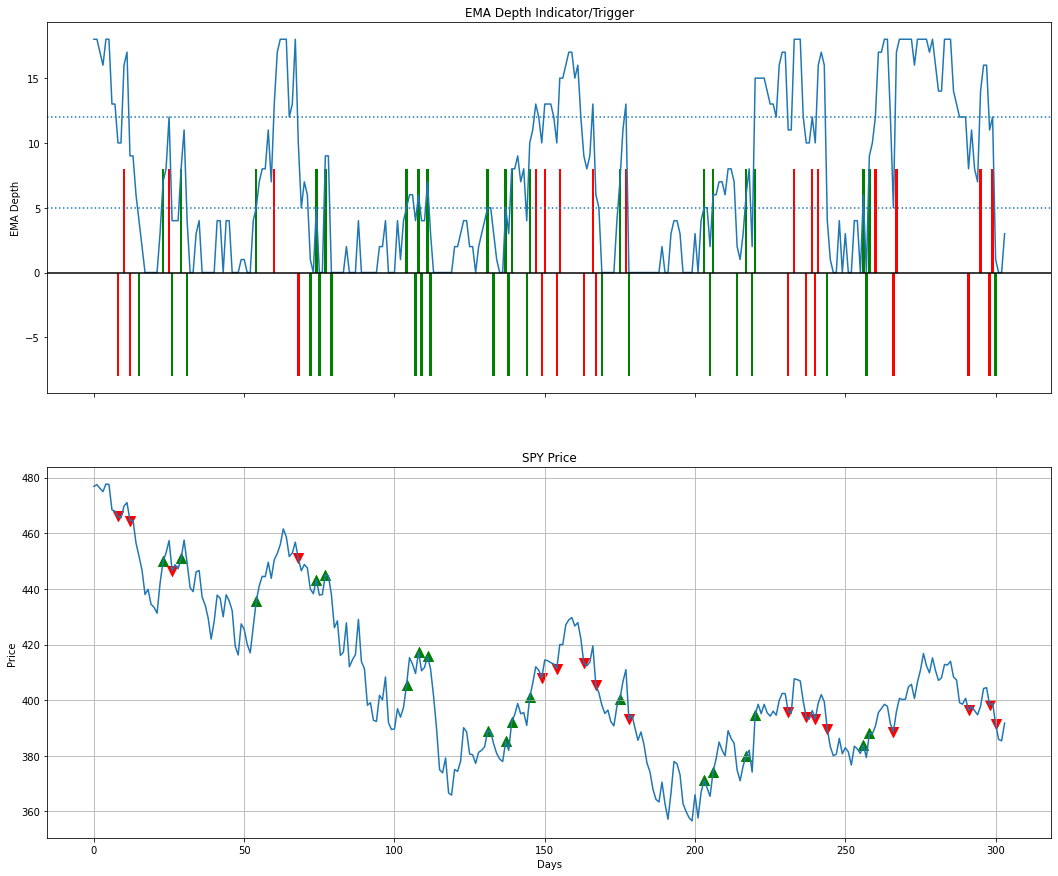

In [487]:
# Testing out using a high and low threshold to generate buy/sell triggers
# Needs tweaking

hi = 12
low = 5
X = df.index.values
depth = countDepth(df, mu)
triggersHi = trigger(countDepth(df, mu), hi)
triggersLow = trigger(countDepth(df, mu), low)
pos = [i for i, v in enumerate(triggersLow) if v==1]
neg = [i for i, v in enumerate(triggersHi) if v==-1]

fig, ax = plt.subplots(2, figsize=(18,15), sharex=True)

ax[0].plot(depth)
ax[0].bar(X, 8*triggersHi, color='red')
ax[0].bar(X, 8*triggersLow, color='green')

ax[0].axhline(y=hi, linestyle='dotted')
ax[0].axhline(y=low, linestyle='dotted')
ax[0].axhline(y=0, color='black')

#ax[0].legend(('EMA Depth', 'Trigger'), loc='upper right')
ax[0].set_title('EMA Depth Indicator/Trigger')
ax[0].set_ylabel('EMA Depth')

ax[1].plot(df['Close'])
ax[1].scatter(pos, df.loc[pos, 'Close'], color='green', marker='^', s=100)
ax[1].scatter(neg, df.loc[neg, 'Close'], color='red', marker='v', s=100)
ax[1].grid()
ax[1].set_title('SPY Price')
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Price')

#fig.savefig("EMA Depth Indicator th=5-12.pdf", bbox_inches='tight')

plt.show()

<font size="5">**Compute Moving Average Short- and Long-Term Standard Deviation, $\sigma_\Lambda$, $\sigma_\lambda$**</font>

**We calculate the standard deviation $\sigma_n = \sqrt{\langle(\mu_\lambda-\langle\mu_\lambda\rangle)^2\rangle}$ over the first $n$ columns value of $\lambda$, i.e., $\{\mu_\lambda : \lambda\in[1,\dots, n]\}$, and we return an array for all values of $n\in[2, \text{max}]$. The long-range stdv, for large $n$ gives a measure of how far the price is from the long-term EMAs. It gives the full width of the spread of $\mu_\lambda$. The short-range stdv for small $n$ gives a more rapid indication of the price movement. By comparing the short- and long-range stdvs, we can determine if the price is trending up/down, horizontal, or if a trend is reversing. In particular, we look for where the short and long are converging or diverging.**

In [488]:
def stds(data, lambdas):
    stds = np.zeros((data.shape[0], data.shape[1]+1))
    
    for i in range(2, len(lambdas)+1):
        # take the standard deviation of the first i EMAs
        stds[:, i] = data[lambdas[:i]].std(axis='columns')
    
    return stds

In [489]:
sigma = pd.DataFrame(stds(mu, lambdas))
sigma.drop(columns=[0,1], inplace=True)
sigma

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,3.628872,3.295851,2.878905,3.016882,2.796833,2.626374,2.785349,3.699614,4.694713,5.329294,5.777158,6.155785,6.692387,7.436554,8.356693,9.301917,10.403201
1,2.696906,3.860092,3.730446,4.108044,3.956724,3.786220,3.900935,4.653351,5.566998,6.193029,6.615736,6.976860,7.481216,8.182517,9.057087,9.966528,11.026044
2,2.279241,3.761066,4.005594,4.629230,4.671948,4.567292,4.699933,5.378692,6.257475,6.909052,7.333927,7.693673,8.186062,8.861247,9.696804,10.580327,11.607376
3,0.822128,2.115951,3.478693,4.280183,4.614321,4.622632,4.818272,5.506317,6.407229,7.116712,7.574051,7.952251,8.457655,9.134014,9.961772,10.845355,11.862899
4,0.244659,1.134238,3.059915,3.972346,4.512816,4.602586,4.825064,5.493818,6.407936,7.161394,7.644987,8.038158,8.553865,9.234040,10.062309,10.950221,11.959536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,1.706957,1.684760,1.571434,2.305201,2.678254,2.464420,2.576382,2.784981,2.818706,2.858277,3.068012,3.536833,4.301221,4.475066,4.440254,4.482192,4.468347
300,0.126336,0.816382,0.907335,1.761464,2.404586,2.254202,2.315364,2.547984,2.605884,2.626790,2.839803,3.284356,4.105947,4.324129,4.295207,4.334226,4.326239
301,2.285370,1.665730,1.360466,2.276000,3.114729,3.031092,2.853908,2.854505,2.799212,2.733357,2.821377,3.129482,3.884171,4.095109,4.049915,4.065420,4.045856
302,2.613464,2.665174,2.374281,3.315732,4.226194,4.216283,3.905338,3.699877,3.509852,3.345526,3.280129,3.366749,3.916167,4.066165,3.986361,3.955905,3.908780


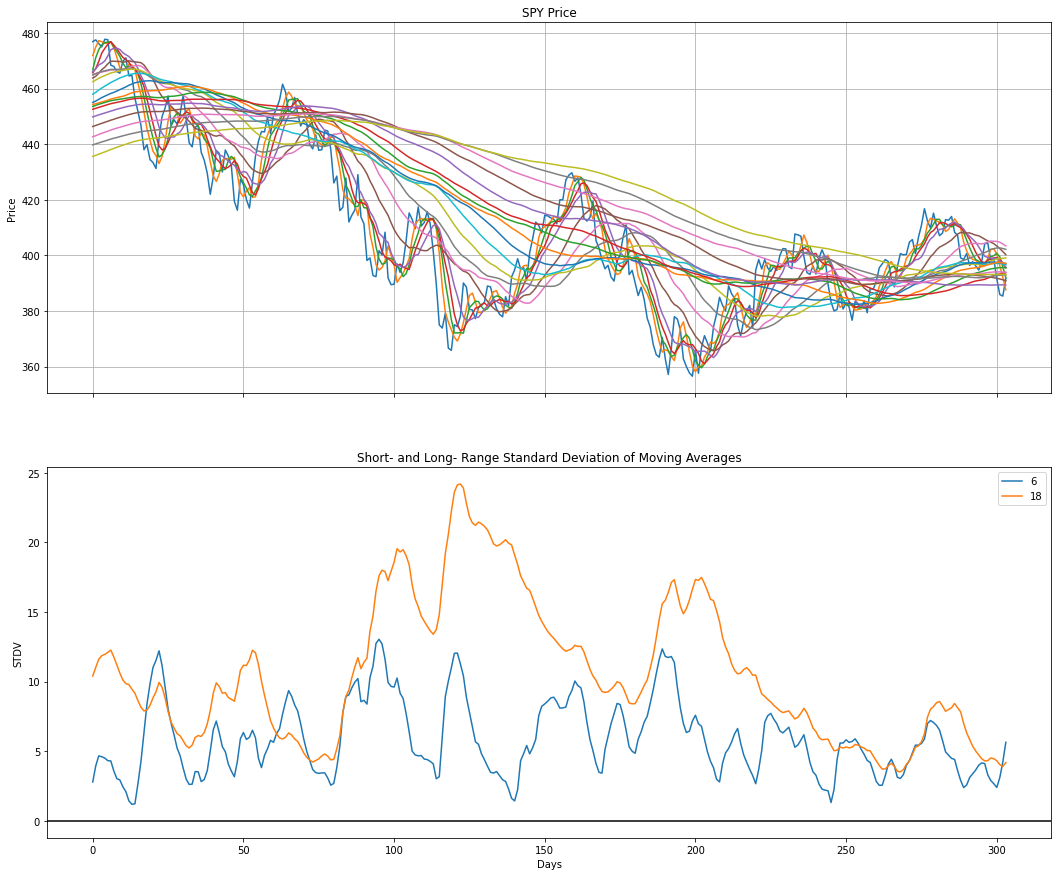

In [490]:
fig, ax = plt.subplots(2, figsize=(18,15), sharex=True)

ax[0].plot(df['Close'])
ax[0].plot(mu)
ax[0].grid()
ax[0].set_title('SPY Price')
ax[0].set_ylabel('Price')

ax[1].plot(sigma[[6, 18]])
ax[1].axhline(y=0, color='black')

ax[1].legend(('6', '18'), loc='upper right')
ax[1].set_title('Short- and Long- Range Standard Deviation of Moving Averages')
ax[1].set_ylabel('STDV')
ax[1].set_xlabel('Days')

fig.savefig("Moving Average STDV-6-18.pdf", bbox_inches='tight')

plt.show()

<font size="5">**Compute the Veclocity of the Moving Averages**</font>

In [491]:
def dmudt(data, lambdas, width):
    window = np.arange(width)
    slopes = np.zeros((len(data), len(lambdas)))
    
    for inx, l in enumerate(lambdas):
        for i in range(width-1, len(data)):
            polyfit = np.polyfit(window, data.loc[i-np.flip(window), l], 1)  # we take the window of the PREVIOUS time steps
            slopes[i, inx] = polyfit[0]
    
    return slopes

In [492]:
slopes = pd.DataFrame(dmudt(mu, lambdas, 5), columns=lambdas)
slopes

,3,5,7,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200
0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.062666,2.423400,2.300143,0.966600,1.01200,0.278767,0.377050,0.54906,0.735133,0.575786,0.303450,0.352289,0.34184,0.344800,0.376429,0.409956,0.345767,0.404645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,1.801999,0.839398,0.422856,-0.546201,-0.55255,0.267800,0.477300,0.39492,0.062900,0.082857,0.304025,0.286667,0.38783,-0.017942,-0.157736,0.129662,0.153128,0.002875
300,1.196334,1.004599,0.439713,-0.182500,-0.58020,0.157433,0.422050,0.38530,0.103017,0.048671,0.284537,0.233833,0.42246,-0.000142,-0.180586,0.108025,0.165239,0.017400
301,-0.692999,0.391000,0.106570,-0.251000,-0.68715,-0.037734,0.289725,0.31176,0.068683,-0.024529,0.207450,0.183456,0.38875,0.015292,-0.213964,0.063231,0.154200,0.021885
302,-2.611332,-0.774999,-0.348715,-0.487400,-0.85780,-0.242033,0.093200,0.22730,-0.021633,-0.094386,0.090400,0.117689,0.34147,0.023600,-0.244821,0.010750,0.130517,0.012485


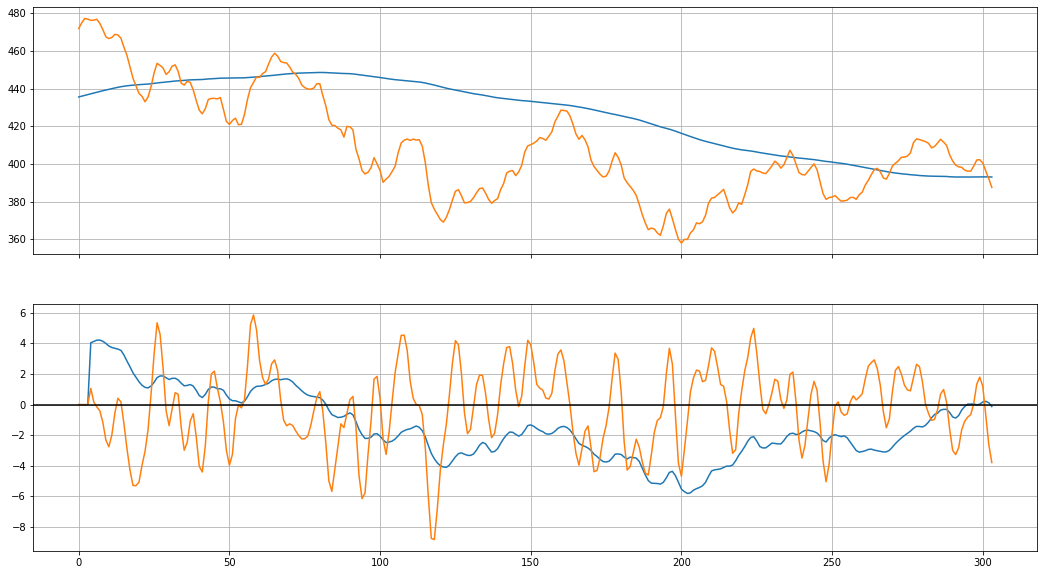

In [493]:
fig, ax = plt.subplots(2, figsize=(18,10), sharex=True)

ax[0].plot(mu[200])
ax[0].plot(mu[3])

ax[1].plot(10*slopes[200])
ax[1].plot(slopes[3])
ax[1].axhline(y=0, color='black')

ax[0].grid()
ax[1].grid()

plt.show()

<font size="5">**Compute the Fourier Spectrum of the Normalized Price, $\bar{x}(t) = x(t) - \mu_\lambda(t)$. $\bar{x}(\nu) = \mathcal{F}[\bar{x}(t)]$**</font>

In [ ]:
from scipy.fftpack import fft, ifft

xbar = np.zeros((len(df.index), len(lambdas)))
for i, l in enumerate(lambdas):
    xbar[:, i] = df['Close'].values - mu[l]
dfbar = pd.DataFrame(xbar, columns=lambdas)

In [ ]:
dfbar

In [ ]:
dfbar.plot(figsize=(18,10), grid=True)

In [ ]:
fft(dfbar[3].values)

In [ ]:
xfreq = np.zeros((len(dfbar.index), len(lambdas)))
for i, l in enumerate(lambdas):
    xfreq[:, i] = fft(dfbar[l].values)
#xfreqdf = pd.DataFrame(xfreq, columns=lambdas)

xfreq

In [494]:
from scipy import signal
from scipy.fft import fftshift

In [495]:
f, t, Sxx = signal.spectrogram(df['Close'].values)

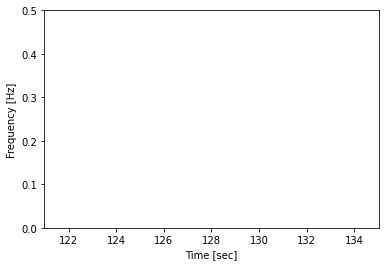

In [496]:
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
plt.show()

In [502]:
import IPython.display as ipd

xbar = df['Close'] - mu[30]
#plt.plot(xbar)
ipd.Audio(xbar, rate=10)

In [504]:
sr = 22050 # sample rate
T = 1.0    # seconds
t = np.linspace(0, T, int(T*sr), endpoint=False) # time variable
x = 0.5*np.sin(2*np.pi*440*t)              # pure sine wave at 440 Hz
ipd.Audio(x, rate=sr)

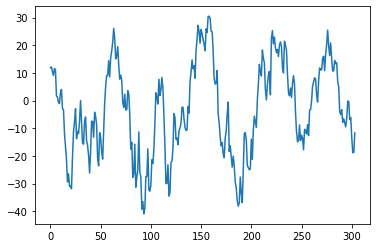

In [506]:
plt.plot(xbar)